In [1]:
from __future__ import annotations
from torch import nn
from torch.nn import functional as F
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
import os
from tqdm import tqdm

import torch
from einops import rearrange
import matplotlib.pyplot as plt
from typing import Tuple, List

from datamodule import DigitDataModule
from unet import SongUnet
from utils import create_animation, plot_generation

Prob = torch.Tensor
Img = torch.Tensor

def pad_like_x(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    # add dims to x to match number of dims in y
    return x.reshape(-1, *(1 for _ in range(y.ndim - x.ndim)))


In [2]:
class KappaScheduler:
    def __init__(self) -> None:
        pass

    def __call__(self, t: float | torch.Tensor) ->  float | torch.Tensor:
        raise NotImplementedError
    
    def derivative(self, t: float | torch.Tensor) -> float | torch.Tensor:
        raise NotImplementedError

class CubicScheduler(KappaScheduler):
    def __init__(self, a: float = 2.0, b: float = 0.5) -> None:
        self.a = a
        self.b = b

    def __call__(self, t: float | torch.Tensor) -> float | torch.Tensor:
        return -2* (t**3) + 3 * (t**2) + self.a * (t ** 3 - 2* t**2 + t) + self.b * (t**3 - t**2)

    def derivative(self, t: float | torch.Tensor) -> float | torch.Tensor:
        return -6 * (t**2) + 6 * t + self.a * (3 * t**2 - 4 * t + 1) + self.b * (3 * t**2 - 2 * t)


In [3]:

def sample_pt(pt: Prob) -> Img:
    b, _, h, w = pt.shape
    pt = rearrange(pt, 'b c h w -> (b h w) c')
    xt = torch.multinomial(pt, 1)
    return xt.reshape(b, h, w)

def sample_cond_pt(p0: Prob, p1: Prob, t: torch.Tensor | float, kappa: KappaScheduler) -> Img:
    t = t.reshape(-1, 1, 1, 1)
    pt = (1 - kappa(t)) * p0 + kappa(t) * p1
    return sample_pt(pt)


def x2prob(x: Img, dict_size: int) -> Prob:
    x = torch.nn.functional.one_hot(x, num_classes=dict_size)
    return rearrange(x, 'b h w c -> b c h w')


In [4]:
class Coupling:
    def __init__(self) -> None:
        pass

    def sample(self, x1: Img) -> tuple[Img, Img]:
        raise NotImplementedError

class Ucoupling(Coupling):
    def __init__(self) -> None:
        pass

    def sample(self, x1: Img) -> tuple[Img, Img]:
        return torch.zeros_like(x1), x1

class Ccoupling(Coupling):
    def __init__(self, msk_prop: float = 0.8) -> None:
        self.msk_prob = msk_prop

    def sample(self, x1: Img) -> tuple[Img, Img]:
        # sample mask
        I = torch.rand_like(x1.float()) > self.msk_prob
        x0 = x1 * I + torch.zeros_like(x1) * (~I)
        return x0, x1


In [5]:


class DiscreteFM(L.LightningModule):
    def __init__(self, dict_size: int,  backbone: nn.Module, coupling: Coupling, kappa: KappaScheduler, sampler:DiscreteSampler) -> None:
        super().__init__()
        self.dict_size = dict_size
        self.backbone = backbone
        self.coupling = coupling
        self.kappa = kappa
        self.sampler = sampler

    def forward(self, t: float | torch.Tensor, x: Img) -> Img:
        return self.backbone(t, x)

    def forward_u(self, t: float | torch.Tensor, xt: Img) -> Prob:
        dirac_xt = x2prob(xt, self.dict_size)
        p1t = torch.softmax(self(t.flatten(), xt), dim=1)

        kappa_coeff = self.kappa.derivative(t) / (1 - self.kappa(t))
        return kappa_coeff * (p1t - dirac_xt)

    def backward_u(self, t: float | torch.Tensor, xt: Img) -> Prob:
        dirac_xt = x2prob(xt, self.dict_size)

        # TODO: adapt to Ccoupling
        x0 = torch.zeros_like(xt)
        p = x2prob(x0, self.dict_size)

        kappa_coeff = self.kappa.derivative(t) / self.kappa(t)
        return kappa_coeff * (dirac_xt - p)

    def bar_u(self, t: float | torch.Tensor, xt: Img, alpha_t: float | torch.Tensor, beta_t: float | torch.Tensor) -> Prob:
        return alpha_t * self.forward_u(t, xt) - beta_t * self.backward_u(t, xt)

    @torch.no_grad()
    def sample(self, sample_size: Tuple[int], n_steps: int = 100) -> Img:
        return self.sampler(sample_size, self, n_steps)


    def step(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        # sample x0, x1 w.r.t. coupling
        x0, x1 = self.coupling.sample(batch[0])

        # sample t ~ U[0, 1]
        t = torch.rand(len(x0), device=self.device)

        # sample pt(.|x0, x1)
        dirac_x0 = x2prob(x0, self.dict_size)
        dirac_x1 = x2prob(x1, self.dict_size)
        xt = sample_cond_pt(dirac_x0, dirac_x1, t, self.kappa)

        # predict p1|t, i.e. (VF - Denoiser)
        p1t = self(t, xt)
        loss = F.cross_entropy(p1t, x1.long())

        return loss


    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        loss = self.step(batch)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        loss = self.step(batch)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=5e-4)
        

    

In [6]:


class DiscreteSampler:
    def __init__(self, adaptative: bool = True) -> None:
        self.h = self.adaptative_h if adaptative else self.constant_h


    def u(self, t: float | torch.Tensor, xt: Img, discretefm: DiscreteFM) -> Prob:
        raise NotImplementedError

    def adaptative_h(self, h: float | torch.Tensor, t: float | torch.Tensor,  discretefm: DiscreteFM) -> float | torch.Tensor:
        raise NotImplementedError

    def constant_h(self, h: float | torch.Tensor, t: float | torch.Tensor,  discretefm: DiscreteFM) -> float | torch.Tensor:
        return h

    def sample_x0(self, sample_size: Tuple[int], device: torch.device, dict_size: int) -> Tuple[Img, Prob]:
        x0 = torch.zeros(sample_size, device=device, dtype=torch.long)
        dirac_x0 = x2prob(x0, dict_size)

        return x0, dirac_x0

    def __call__(self, sample_size: Tuple[int], discretefm: DiscreteFM, n_steps: int, t_min: float = 1e-4) -> List[Img]:

        t = t_min * torch.ones(sample_size[0], device=discretefm.device)
        default_h = 1 / n_steps
        # sample initial x0
        xt, dirac_xt = self.sample_x0(sample_size, discretefm.device, discretefm.dict_size)

        list_xt = [xt]
        t = pad_like_x(t, dirac_xt)

        while t.max() <= 1 - default_h:
            h = self.h(default_h, t, discretefm)
            pt = dirac_xt + h * self.u(t, xt, discretefm)
            # sample xt
            xt = sample_pt(pt)
            dirac_xt = x2prob(xt, discretefm.dict_size)
            t += h
            list_xt.append(xt)
        
        return list_xt

class SimpleSampler(DiscreteSampler):

    def u(self, t: float | torch.Tensor, xt: Img, discretefm: DiscreteFM) -> Prob:
        return discretefm.forward_u(t, xt)

    def adaptative_h(self, h: float | torch.Tensor, t: float | torch.Tensor, discretefm: DiscreteFM) -> float | torch.Tensor:

        coeff = (1 - discretefm.kappa(t)) / discretefm.kappa.derivative(t)
        h = torch.tensor(h, device=discretefm.device)
        h_adapt = torch.minimum(h, coeff)
        return h_adapt

class CorrectorSampler(DiscreteSampler):
    def __init__(self, adaptative: bool = True, alpha: float = 12., a: float = 2.,  b: float = 0.25) -> None:
        super().__init__(adaptative)
        # best hyperparameters for image generation (w.r.t. the paper)
        self.alpha = alpha
        self.a, self.b = a, b
        self.alpha_t = lambda t: 1 + (self.alpha * (t ** self.a)) * ((1 - t) ** self.b)
        self.beta_t = lambda t: self.alpha_t(t) - 1

    def u(self, t: float | torch.Tensor, xt: Img, discretefm: DiscreteFM) -> Prob:
        return discretefm.bar_u(t, xt, self.alpha_t(t), self.beta_t(t))

    def adaptative_h(self, h: float | torch.Tensor, t: float | torch.Tensor, discretefm: DiscreteFM) -> float | torch.Tensor:

        alpha_term = self.alpha_t(t) * discretefm.kappa.derivative(t) / (1 - discretefm.kappa(t))
        beta_term = self.beta_t(t) * discretefm.kappa.derivative(t) / discretefm.kappa(t)
        coeff = 1 / (alpha_term + beta_term)

        h = torch.tensor(h, device=discretefm.device)
        h_adapt = torch.minimum(h, coeff)
        return h_adapt

In [7]:

DICT_SIZE = 10
MODEL_CHANNELS = 64
unet =  SongUnet(img_resolution = 32,  # Image resolution at input/output.
    in_channels = 1,  
    out_channels = DICT_SIZE,
    model_channels= MODEL_CHANNELS)  
coupling = Ucoupling()
kappa = CubicScheduler()
sampler = SimpleSampler()
# sampler = CorrectorSampler()

discretefm = DiscreteFM(DICT_SIZE, unet, coupling, kappa, sampler)

dm = DigitDataModule(dict_size=DICT_SIZE, batch_size=450)
dm.setup()

# launch training
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
trainer = L.Trainer(max_epochs=50, logger=TensorBoardLogger('lightning_logs'))
trainer.fit(discretefm, dm)


# save model

save_path = f'discretefm-{MODEL_CHANNELS}.pt'
torch.save(discretefm.state_dict(), save_path)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | backbone | SongUnet | 15.5 M
--------------------------------------
15.5 M    Trainable params
0         Non-trainable params
15.5 M    Total params
61.918    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


## Inference

In [8]:
# load model
MODEL_CHANNELS = 32
load_path = f'discretefm-{MODEL_CHANNELS}.pt'
unet =  SongUnet(img_resolution = 32,  # Image resolution at input/output.
    in_channels = 1,  
    out_channels = DICT_SIZE,
    model_channels= MODEL_CHANNELS)  
coupling = Ucoupling()
kappa = CubicScheduler()
sampler = SimpleSampler()
discretefm = DiscreteFM(DICT_SIZE, unet, coupling, kappa, sampler)
discretefm.load_state_dict(torch.load(load_path))
discretefm.eval()

DiscreteFM(
  (backbone): SongUnet(
    (map_noise): PositionalEmbedding()
    (map_layer0): Linear()
    (map_layer1): Linear()
    (enc): ModuleDict(
      (32x32_conv): Conv2d()
      (32x32_block0): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block1): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block2): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block3): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (16x16_down): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Lin

### Sampling

In [9]:


sample_size = (16, 32, 32)
N_STEPS = 1024

# LOAD SAMPLER 
#sampler = SimpleSampler(adaptative=True)

#sampler = CorrectorSampler(adaptative=True, a=1, b=1, alpha=1)
sampler = CorrectorSampler(adaptative=True)
# t = torch.linspace(0, 1, N_STEPS, device=discretefm.device)
# plt.figure(figsize=(10, 10))
# plt.plot(t, sampler.alpha_t(t), label='alpha(t)')
# plt.plot(t, sampler.beta_t(t), label='beta(t)')
# plt.legend()
# plt.show()

In [10]:
with torch.no_grad():
    xts = sampler(sample_size, discretefm, N_STEPS)

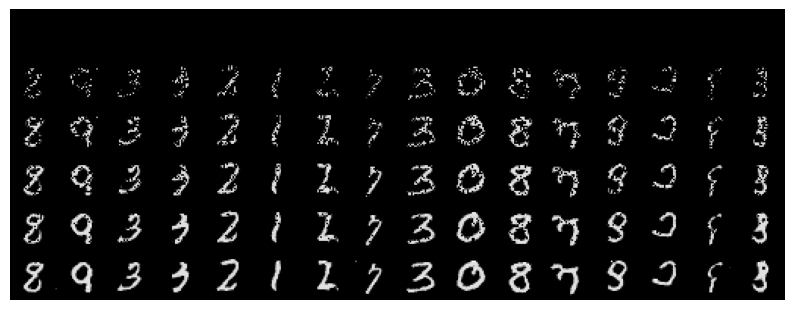

In [11]:
plot_generation(xts, n_plots=5)

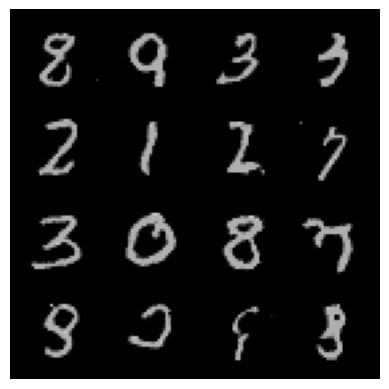

In [12]:
create_animation(xts, 'digits.gif', duration=5, dict_size=DICT_SIZE)